In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.models import alexnet
import torch.nn.functional as F
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

from AlexNetLastTwoLayers import AlexNetLastTwoLayers
from PrototypicalNetworks import PrototypicalNetworks
from PrototypicalFlagNetworks import PrototypicalFlagNetworks

from statistics import mean

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
random_seed = 0
# np.random.seed(random_seed)
torch.manual_seed(random_seed)
# random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:

transform = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
        ]
)


train_data = CIFAR10(
    root="../data",
    transform= transform,
    download=True,
    train = True
)
test_data = CIFAR10(
    root="../data",
    transform=transform,
    download=True,
    train = False   
)


# split of training data into train and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])


Files already downloaded and verified
Files already downloaded and verified


In [5]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
val_subset.get_labels = lambda: [
    instance[1] for instance in val_subset
]
test_data.get_labels = lambda: [
    instance[1] for instance in test_data
]

test_sampler = TaskSampler(
    test_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

val_sampler = TaskSampler(
    val_subset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_data,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
    shuffle = False
)

val_loader = DataLoader(
    val_subset,
    batch_sampler=val_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
    shuffle = False
)



N_TASKS_PER_EPOCH = 500
N_VALIDATION_TASKS = 100

train_data.get_labels = lambda: [instance[1] for instance in train_data]

train_sampler = TaskSampler(
    train_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TASKS_PER_EPOCH
)

train_loader = DataLoader(
    train_data,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


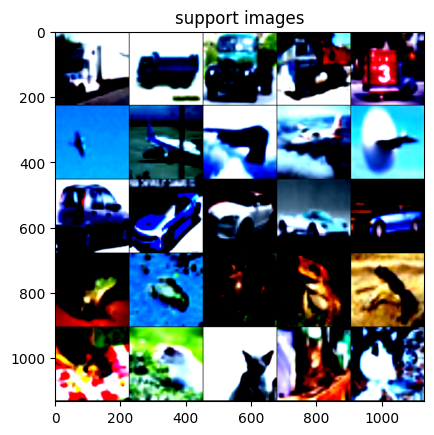

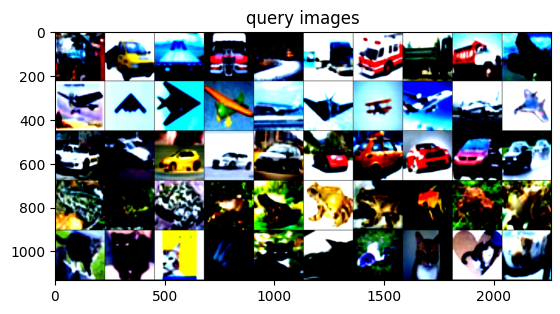

In [6]:
# (
#     example_support_images,
#     example_support_labels,
#     example_query_images,
#     example_query_labels,
#     example_class_ids,
# ) = next(iter(test_loader))

# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [7]:
# backbone = alexnet(pretrained = True)
# backbone.classifier[6] = nn.Flatten()
# model = PrototypicalNetworks(backbone, head = 'SubspaceNet')

backbone = alexnet(pretrained = True)
backbone.classifier[6] = nn.Flatten()
model = PrototypicalNetworks(backbone, head = 'ProtoNet').to(device)

# my_alexnet = alexnet(pretrained = True)
# backbone = AlexNetLastTwoLayers(my_alexnet)
# model = PrototypicalFlagNetworks(backbone)

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model.eval()
example_scores = model(
    example_support_images.to(device),
    example_support_labels.to(device),
    example_query_images.to(device),
).detach()

example_predicted_labels = torch.argmax(torch.squeeze(example_scores, axis=0),axis = 1)

In [9]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """


    return (
            torch.argmax(
             torch.squeeze(
                model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, axis=0)
                ,axis = 1
                )
               ==example_query_labels.cuda()).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:07<00:00, 12.81it/s]

Model tested on 100 tasks. Accuracy: 19.86%


In [10]:
def count_accuracy(logits, label):
    pred = torch.argmax(logits, dim=1).view(-1)
    label = label.view(-1)
    accuracy = 100 * pred.eq(label).float().mean()
    return accuracy

In [11]:
def one_hot(indices, depth):
    """
    Returns a one-hot tensor.
    This is a PyTorch equivalent of Tensorflow's tf.one_hot.
        
    Parameters:
      indices:  a (n_batch, m) Tensor or (m) Tensor.
      depth: a scalar. Represents the depth of the one hot dimension.
    Returns: a (n_batch, m, depth) Tensor or (m, depth) Tensor.
    """

    encoded_indicies = torch.zeros(indices.size() + torch.Size([depth])).cuda()
    index = indices.view(indices.size()+torch.Size([1]))
    encoded_indicies = encoded_indicies.scatter_(1,index,1)
    
    return encoded_indicies

In [12]:

def training_epoch(model_, data_loader, optimizer):
    all_loss = []
    model_.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()

            logit_query = model_(support_images.cuda(), support_labels.cuda(), query_images.cuda())

            train_way = len(torch.unique(support_labels))
            smoothed_one_hot = one_hot(query_labels.reshape(-1).cuda(), train_way)
            log_prb = F.log_softmax(logit_query.reshape(-1, train_way), dim=1)
            loss = -(smoothed_one_hot * log_prb).sum(dim=1)
            loss = loss.mean()

            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [13]:
def val_evaluate(model_, val_loader):
    model_.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed during validation
        for val_support_images, val_support_labels, val_query_images, val_query_labels, _ in val_loader:
            # Obtain validation predictions
            val_preds = model_(val_support_images.cuda(), val_support_labels.cuda(), val_query_images.cuda())
            
            # Count correct predictions
            correct += (val_preds.argmax(dim=2).reshape(-1) == val_query_labels.cuda()).sum().item()
            total += val_query_labels.size(0)

    # Calculate validation accuracy
    val_accuracy = correct / total
    return val_accuracy

In [14]:

import copy

train_optimizer = optim.Adam(model.parameters(), lr=1e-5)
n_epochs = 100

best_state = model.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)
    validation_accuracy = val_evaluate(model, val_loader)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(model.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        print(f"Ding ding ding! We found a new best model! {best_validation_accuracy}")

    # tb_writer.add_scalar("Train/loss", average_loss, epoch)
    # tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    # train_scheduler.step()

Epoch 0


Training: 100%|██████████| 500/500 [01:19<00:00,  6.32it/s, loss=0.625]


Ding ding ding! We found a new best model! 0.8296
Epoch 1


Training: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s, loss=0.409]


Ding ding ding! We found a new best model! 0.869
Epoch 2


Training: 100%|██████████| 500/500 [01:23<00:00,  5.96it/s, loss=0.353]


Ding ding ding! We found a new best model! 0.8864
Epoch 3


Training: 100%|██████████| 500/500 [01:26<00:00,  5.78it/s, loss=0.3]  


Ding ding ding! We found a new best model! 0.9032
Epoch 4


Training: 100%|██████████| 500/500 [01:22<00:00,  6.09it/s, loss=0.287]


Ding ding ding! We found a new best model! 0.9088
Epoch 5


Training: 100%|██████████| 500/500 [01:24<00:00,  5.89it/s, loss=0.264]


Ding ding ding! We found a new best model! 0.9262
Epoch 6


Training: 100%|██████████| 500/500 [01:24<00:00,  5.92it/s, loss=0.25] 


Ding ding ding! We found a new best model! 0.9278
Epoch 7


Training: 100%|██████████| 500/500 [01:23<00:00,  5.99it/s, loss=0.216]


Ding ding ding! We found a new best model! 0.9308
Epoch 8


Training: 100%|██████████| 500/500 [01:26<00:00,  5.79it/s, loss=0.221]


Ding ding ding! We found a new best model! 0.9396
Epoch 9


Training: 100%|██████████| 500/500 [01:25<00:00,  5.84it/s, loss=0.207]


Ding ding ding! We found a new best model! 0.9402
Epoch 10


Training: 100%|██████████| 500/500 [01:28<00:00,  5.68it/s, loss=0.194]


Ding ding ding! We found a new best model! 0.949
Epoch 11


Training: 100%|██████████| 500/500 [01:27<00:00,  5.72it/s, loss=0.189]


Epoch 12


Training: 100%|██████████| 500/500 [01:26<00:00,  5.75it/s, loss=0.173]


Ding ding ding! We found a new best model! 0.95
Epoch 13


Training: 100%|██████████| 500/500 [01:27<00:00,  5.73it/s, loss=0.17] 


Ding ding ding! We found a new best model! 0.9544
Epoch 14


Training: 100%|██████████| 500/500 [01:25<00:00,  5.86it/s, loss=0.16] 


Epoch 15


Training: 100%|██████████| 500/500 [01:26<00:00,  5.80it/s, loss=0.153]


Ding ding ding! We found a new best model! 0.957
Epoch 16


Training: 100%|██████████| 500/500 [01:28<00:00,  5.68it/s, loss=0.153]


Epoch 17


Training: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s, loss=0.145]


Ding ding ding! We found a new best model! 0.9648
Epoch 18


Training: 100%|██████████| 500/500 [01:24<00:00,  5.94it/s, loss=0.138]


Epoch 19


Training: 100%|██████████| 500/500 [01:23<00:00,  6.01it/s, loss=0.139]


Ding ding ding! We found a new best model! 0.968
Epoch 20


Training: 100%|██████████| 500/500 [01:24<00:00,  5.93it/s, loss=0.12] 


Epoch 21


Training: 100%|██████████| 500/500 [01:23<00:00,  5.99it/s, loss=0.12] 


Epoch 22


Training: 100%|██████████| 500/500 [01:23<00:00,  5.98it/s, loss=0.126]


Ding ding ding! We found a new best model! 0.97
Epoch 23


Training: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s, loss=0.11] 


Epoch 24


Training: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s, loss=0.107] 


Ding ding ding! We found a new best model! 0.9754
Epoch 25


Training: 100%|██████████| 500/500 [01:27<00:00,  5.72it/s, loss=0.107]


Epoch 26


Training: 100%|██████████| 500/500 [01:28<00:00,  5.68it/s, loss=0.0983]


Ding ding ding! We found a new best model! 0.9772
Epoch 27


Training: 100%|██████████| 500/500 [01:24<00:00,  5.89it/s, loss=0.102] 


Epoch 28


Training: 100%|██████████| 500/500 [01:26<00:00,  5.77it/s, loss=0.0909]


Ding ding ding! We found a new best model! 0.9784
Epoch 29


Training: 100%|██████████| 500/500 [01:27<00:00,  5.70it/s, loss=0.0904]


Epoch 30


Training: 100%|██████████| 500/500 [01:27<00:00,  5.74it/s, loss=0.0876]


Ding ding ding! We found a new best model! 0.9798
Epoch 31


Training: 100%|██████████| 500/500 [01:25<00:00,  5.86it/s, loss=0.0806]


Epoch 32


Training: 100%|██████████| 500/500 [01:24<00:00,  5.93it/s, loss=0.0817]


Epoch 33


Training: 100%|██████████| 500/500 [01:24<00:00,  5.94it/s, loss=0.075] 


Ding ding ding! We found a new best model! 0.9816
Epoch 34


Training: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s, loss=0.0706]


Epoch 35


Training: 100%|██████████| 500/500 [01:27<00:00,  5.70it/s, loss=0.0719]


Ding ding ding! We found a new best model! 0.9846
Epoch 36


Training:  21%|██        | 104/500 [00:18<01:09,  5.73it/s, loss=0.0735]


KeyboardInterrupt: 

In [35]:
# # criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-5)#lr=0.0001)#lr=0.001)



# def fit(
#     support_images: torch.Tensor,
#     support_labels: torch.Tensor,
#     query_images: torch.Tensor,
#     query_labels: torch.Tensor,
# ) -> float:
#     optimizer.zero_grad()

#     logit_query = model(
#         support_images.cuda(), support_labels.cuda(), query_images.cuda()
#     )

#     train_way = len(torch.unique(support_labels))
#     smoothed_one_hot = one_hot(query_labels.reshape(-1).cuda(), train_way)
#     log_prb = F.log_softmax(logit_query.reshape(-1, train_way), dim=1)
#     loss = -(smoothed_one_hot * log_prb).sum(dim=1)
#     loss = loss.mean()

#     acc = count_accuracy(logit_query.reshape(-1, train_way), query_labels.reshape(-1))

#     loss.backward()
#     optimizer.step()

#     return loss.item(), acc.item()

In [36]:

# log_update_frequency = 10

# all_loss = []
# all_acc = []
# model.train()
# with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
#     for episode_index, (
#         support_images,
#         support_labels,
#         query_images,
#         query_labels,
#         _,
#     ) in tqdm_train:
#         loss_value, acc_value = fit(support_images.cuda(), support_labels.cuda(), query_images.cuda(), query_labels.cuda())
#         all_loss.append(loss_value)
#         all_acc.append(acc_value)
        

#         if episode_index % log_update_frequency == 0:
#             avg_loss = sliding_average(all_loss, log_update_frequency)
#             avg_acc = sliding_average(all_acc, log_update_frequency)

#             tqdm_train.set_postfix(loss=avg_loss, acc = avg_acc)

  6%|▌         | 2467/40000 [06:47<1:43:13,  6.06it/s, acc=92.2, loss=0.217]


KeyboardInterrupt: 

In [15]:
# model

PrototypicalNetworks(
  (backbone): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=

In [37]:
# torch.save(model.state_dict(), 'last_epoch.pth')

In [14]:
# backbone = alexnet(pretrained = True)
# backbone.classifier[6] = nn.Flatten()
# model = PrototypicalNetworks(backbone, head = 'ProtoNet')
# model.load_state_dict(torch.load('last_epoch.pth', weights_only=True))

<All keys matched successfully>

In [4]:
# # INCORPERATE THIS TO HAVE EPOCHS:

# # https://github.com/sicara/easy-few-shot-learning/blob/master/notebooks/classical_training.ipynb
# from easyfsl.utils import evaluate


# best_state = model.state_dict()
# best_validation_accuracy = 0.0
# validation_frequency = 10
# for epoch in range(n_epochs):
#     print(f"Epoch {epoch}")
#     average_loss = training_epoch(model, train_loader, train_optimizer)

#     if epoch % validation_frequency == validation_frequency - 1:

#         # We use this very convenient method from EasyFSL's ResNet to specify
#         # that the model shouldn't use its last fully connected layer during validation.
#         model.set_use_fc(False)
#         validation_accuracy = evaluate(
#             few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
#         )
#         model.set_use_fc(True)

#         if validation_accuracy > best_validation_accuracy:
#             best_validation_accuracy = validation_accuracy
#             best_state = copy.deepcopy(few_shot_classifier.state_dict())
#             # state_dict() returns a reference to the still evolving model's state so we deepcopy
#             # https://pytorch.org/tutorials/beginner/saving_loading_models
#             print("Ding ding ding! We found a new best model!")

#         tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

#     tb_writer.add_scalar("Train/loss", average_loss, epoch)

#     # Warn the scheduler that we did an epoch
#     # so it knows when to decrease the learning rate
#     train_scheduler.step()

In [5]:
# WHY IS THERE NO REPRODUCIBILITY HERE???

In [39]:
# Validation step



In [40]:
val_accuracy

0.9068

In [20]:
val_accuracy 

0.8432

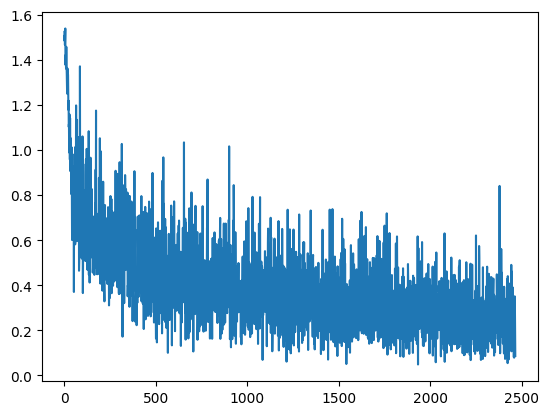

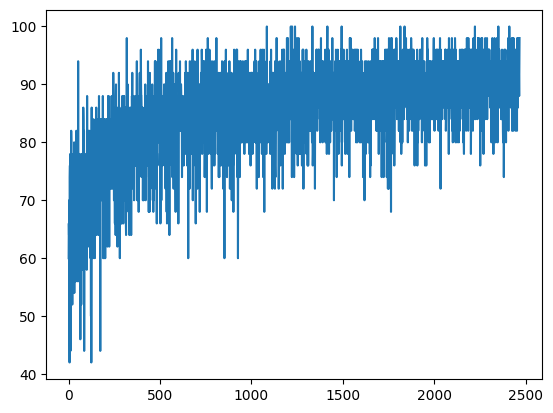

In [41]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(all_loss)


plt.figure()
plt.plot(all_acc)

In [14]:
evaluate(val_loader)

100%|██████████| 100/100 [00:35<00:00,  2.84it/s]

Model tested on 100 tasks. Accuracy: 18.08%
